<a href="https://colab.research.google.com/github/rifahtasnia/CN_Commodity_Demand_Forecasting/blob/master/CN_Commodity_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas scikit-learn numpy

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Dataset Loading

In [2]:
participant_data = pd.read_csv("/content/participant_data.csv")


In [7]:
participant_data['Date'] = pd.to_datetime(participant_data['Date'])

# Data Analysis

In [6]:
participant_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7710 entries, 0 to 7709
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  7710 non-null   int64  
 1   Date                7710 non-null   object 
 2   Year                7710 non-null   int64  
 3   Quarter             7710 non-null   int64  
 4   Month               7710 non-null   int64  
 5   Week                7710 non-null   int64  
 6   Country             7710 non-null   object 
 7   Commodity Type      7710 non-null   object 
 8   Commodity Category  7710 non-null   object 
 9   Commodity           7710 non-null   object 
 10  Movement            7710 non-null   object 
 11  Units               5782 non-null   float64
dtypes: float64(1), int64(5), object(6)
memory usage: 722.9+ KB


In [3]:
participant_data.head(5)

,id,Date,Year,Quarter,Month,Week,Country,Commodity Type,Commodity Category,Commodity,Movement,Units
0,0,2000-01-03T00:00:00.000Z,2000,1,1,1,Canada,C,Carload Traffic,10,Originated,2094.0
1,1,2000-01-03T00:00:00.000Z,2000,1,1,1,Canada,I,Intermodal Traffic,IC,Originated,6389.0
2,2,2000-01-03T00:00:00.000Z,2000,1,1,1,Canada,I,Intermodal Traffic,IT,Originated,2510.0
3,3,2000-01-03T00:00:00.000Z,2000,1,1,1,Canada,C,Carload Traffic,10,Received,NaN
4,4,2000-01-03T00:00:00.000Z,2000,1,1,1,Canada,I,Intermodal Traffic,IC,Received,NaN


In [10]:
null_values = participant_data.isnull().sum()
notnull_values = participant_data.notnull().sum()

null_values, notnull_values

(id                       0
 Date                     0
 Year                     0
 Quarter                  0
 Month                    0
 Week                     0
 Country                  0
 Commodity Type           0
 Commodity Category       0
 Commodity                0
 Movement                 0
 Units                 1928
 dtype: int64,
 id                    7710
 Date                  7710
 Year                  7710
 Quarter               7710
 Month                 7710
 Week                  7710
 Country               7710
 Commodity Type        7710
 Commodity Category    7710
 Commodity             7710
 Movement              7710
 Units                 5782
 dtype: int64)

The Units column, which appears to be the target variable, has 1,928 missing values out of 7,710 entries

In [17]:
numerical_summary = participant_data.describe()

numerical_summary

,id,Year,Quarter,Month,Week,Units
count,7710.000000,7710.000000,7710.000000,7710.000000,7710.000000,5782.000000
mean,3854.500000,2011.708949,2.494942,6.465370,26.455253,6408.938948
std,2225.829621,7.082587,1.119834,3.467437,15.129964,13380.897634
min,0.000000,2000.000000,1.000000,1.000000,1.000000,0.000000
25%,1927.250000,2006.000000,1.000000,3.000000,13.000000,277.000000
50%,3854.500000,2012.000000,2.000000,6.000000,26.000000,707.500000
75%,5781.750000,2018.000000,4.000000,10.000000,40.000000,2711.000000
max,7709.000000,2024.000000,4.000000,12.000000,52.000000,86048.000000


The dataset covers a 24-year period ranging from 2000 to 2024.

The Units distribution is highly skewed. The large standard deviation (13,381 units) and a maximum value of 86,048 units suggest significant variability in Units.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

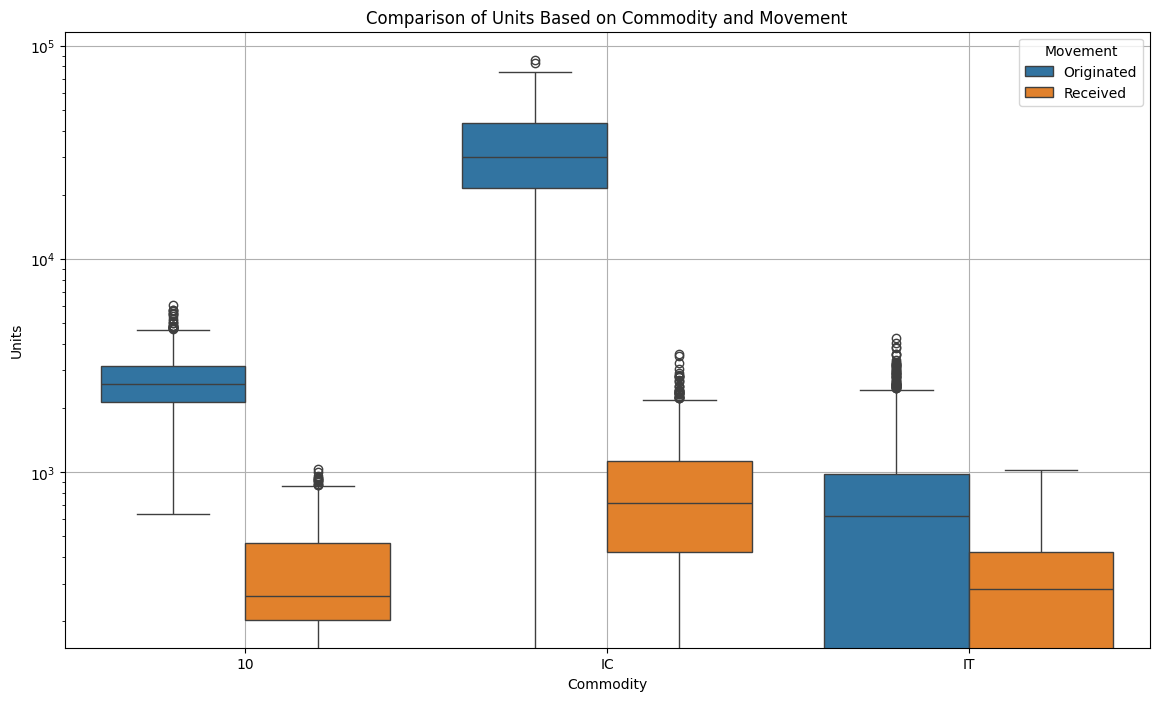

In [15]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=participant_data, x='Commodity', y='Units', hue='Movement')
plt.title('Comparison of Units Based on Commodity and Movement')
plt.xlabel('Commodity')
plt.ylabel('Units')
plt.yscale('log')
plt.grid(True)
plt.legend(title='Movement', loc='upper right')
plt.show()



*   Impact of Movement on Units: Originated movements generally have a higher distribution of Units compared to Received movements.
*   Impact of Commodity on Units: Different commodities have distinct distributions of Units. For example, commodities such as IC tend to have higher unit values compared to others.
*   Commodity IC with Originated shows higher Units on average.
*   Commodity 10 with Received has a lower spread, indicating less variation in unit counts.






# Feature Engineering

In [18]:
training_data = participant_data[participant_data['Units'].notnull()]
missing_units_data = participant_data[participant_data['Units'].isnull()]


training_data['Month_Quarter'] = training_data['Month'] / training_data['Quarter']
training_data['Year_Week'] = training_data['Year'] + training_data['Week'] / 52


features = ['Year', 'Quarter', 'Month', 'Week', 'Month_Quarter', 'Year_Week',
            'Country', 'Commodity Type', 'Commodity Category', 'Commodity', 'Movement']


#features = ['Year', 'Quarter', 'Month', 'Week', 'Country', 'Commodity Type', 'Commodity Category', 'Commodity', 'Movement']
target = 'Units'


numeric_features = ['Year', 'Quarter', 'Month', 'Week', 'Month_Quarter', 'Year_Week']
categorical_features = ['Country', 'Commodity Type', 'Commodity Category', 'Commodity', 'Movement']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])



<ipython-input-18-124216d56cc2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['Month_Quarter'] = training_data['Month'] / training_data['Quarter']
<ipython-input-18-124216d56cc2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['Year_Week'] = training_data['Year'] + training_data['Week'] / 52


# Model Training

In [19]:
model = RandomForestRegressor(random_state=42)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])


X = training_data[features]
y = training_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def smape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))) * 100

smape_scorer = make_scorer(smape, greater_is_better=False)



param_grid = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [5, 10, 20, None],
    'regressor__min_samples_split': [2, 5, 10, 15],
    'regressor__min_samples_leaf': [1, 2, 5, 10],
    'regressor__max_features': ['sqrt', 'log2', 0.3, 0.5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=smape_scorer, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Year',
                                                                          'Quarter',
                                                                          'Month',
                                                                          'Week',
                                                                          'Month_Quarter',
                                                                          'Year_Week']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Country',
                                                                          'Commodity '
                                                                          'Type',
                                                                          'Commodity '
                                                                          'Category',
                                                                          'Commodity',
                                                                          'Movement'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [5, 10, 20, None],
                         'regressor__max_features': ['sqrt', 'log2', 0.3, 0.5],
                         'regressor__min_samples_leaf': [1, 2, 5, 10],
                         'regressor__min_samples_split': [2, 5, 10, 15],
                         'regressor__n_estimators': [50, 100, 200, 300]},
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

# Evaluation of Model

In [20]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
smape_value = smape(y_test, y_pred)
r2_value = r2_score(y_test, y_pred)

print(f'SMAPE: {smape_value}')
print(f'R² Score: {r2_value}')


SMAPE: 26.274112254891147
R² Score: 0.9256330809884267


#Predict Units with Missing Rows

In [21]:
missing_units_data['Month_Quarter'] = missing_units_data['Month'] / missing_units_data['Quarter']
missing_units_data['Year_Week'] = missing_units_data['Year'] + missing_units_data['Week'] / 52

X_missing = missing_units_data[features]
missing_units_data['Predicted Units'] = best_model.predict(X_missing)

output_df = missing_units_data[['id', 'Predicted Units']]


#output_file = "/content/predicted_units.csv"
#output_df.to_csv(output_file, index=False)

# Replace the missing 'Units' values in the original dataset with the predictions
participant_data.loc[participant_data['Units'].isnull(), 'Units'] = missing_units_data['Predicted Units']

final_dataset_path = "/content/participant_data_with_predictions.csv"
participant_data.to_csv(final_dataset_path, index=False)


final_dataset_path


<ipython-input-21-8abb89dd0f86>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_units_data['Month_Quarter'] = missing_units_data['Month'] / missing_units_data['Quarter']
<ipython-input-21-8abb89dd0f86>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_units_data['Year_Week'] = missing_units_data['Year'] + missing_units_data['Week'] / 52
<ipython-input-21-8abb89dd0f86>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

'/content/participant_data_with_predictions.csv'